In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# define model potential

# when only one RC will do

In [3]:
def single_sgoop_potential(x, y):
    return (
        -12 * np.exp(-4.5 * np.square(x + 0.75) - 3 * np.square(y + 0.5))
        - 16 * np.exp(-2 * np.square(x) - 2 * np.square(y - 1))
        - 12 * np.exp(-4.5 * np.square(x - 0.75) - 3 * np.square(y + 0.5))
        + 0.05 * (np.power(x, 6) + np.power(y, 6))
    )

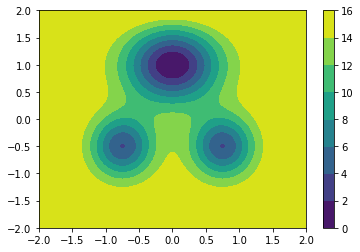

In [4]:
# calculate 2D potential energy surface
xaxis = np.linspace(-2.0, 2.0, 100)
yaxis = np.linspace(-2.0, 2.0, 100)

potential_energy_surface = single_sgoop_potential(
    xaxis[:, None], yaxis[None, :]
) 

# shift and clip high energy values for visualization
max_val = 16
shifted_pes = potential_energy_surface - potential_energy_surface.min()
shifted_pes[shifted_pes > max_val] = max_val

# plot potential energy surface
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')

In [5]:
# intialize empty pandas DataFrame to hold mock MD traj
md_traj = pd.DataFrame(
    columns=['x', 'y', 'weights']
)
x_col = []
y_col = []
weight_col = []

# step through potential energy surface, assigning weight (probability)
# to each square.
for idx, energy in np.ndenumerate(potential_energy_surface):
    x = xaxis[idx[0]]
    y = yaxis[idx[1]]
    x_col.append(x)
    y_col.append(y)
    weight_col.append(np.exp(-energy))
md_traj['x'] = x_col
md_traj['y'] = y_col
md_traj['weights'] = weight_col

In [6]:
from sgoop.sgoop import sgoop, md_prob

In [7]:
# specify columns you want to require
sgoop_params = {
    # specify rbias and cv column names
    'cv_cols': ['x', 'y'],
    # adjust sgoop params
    'rc_bins': 50,
    'wells': 3,
    'd': 5,
    'kde': True,
    'bw': 0.01,
    'diffusivity': 1.0
}


In [8]:
def angle_to_rc(angle):
    x = np.cos(angle)
    y = np.sin(angle)
    return np.array([x, y])

rc 0:  angle:  0.000  sg:  0.088
rc 1:  angle:  0.083  sg:  0.004
rc 2:  angle:  0.165  sg:  0.008
rc 3:  angle:  0.248  sg:  0.010
rc 4:  angle:  0.331  sg:  0.008
rc 5:  angle:  0.413  sg:  0.010
rc 6:  angle:  0.496  sg:  0.010
rc 7:  angle:  0.579  sg:  0.010
rc 8:  angle:  0.661  sg:  0.010
rc 9:  angle:  0.744  sg:  0.008
rc10:  angle:  0.827  sg:  0.004
rc11:  angle:  0.909  sg:  0.001
rc12:  angle:  0.992  sg:  0.003
rc13:  angle:  1.075  sg:  0.015
rc14:  angle:  1.157  sg:  0.014
rc15:  angle:  1.240  sg:  0.002
rc16:  angle:  1.323  sg:  0.010
rc17:  angle:  1.405  sg:  0.006
rc18:  angle:  1.488  sg:  0.003
rc19:  angle:  1.571  sg:  0.009
optimized RC: [1. 0.]
spectral gap: 0.08815499059879839


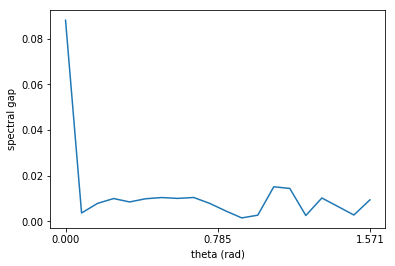

In [9]:
# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    prob, grid = md_prob(
        rc,
        md_traj,
        sgoop_params['cv_cols'],
        md_traj['weights'].values,
        sgoop_params['rc_bins'],
        sgoop_params['kde'],
        sgoop_params['bw']
    )
    # calculate spectral gap
    sg[idx] = sgoop(
        prob,
        None,
        sgoop_params['d'],
        sgoop_params['wells'],
        sgoop_params['diffusivity'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

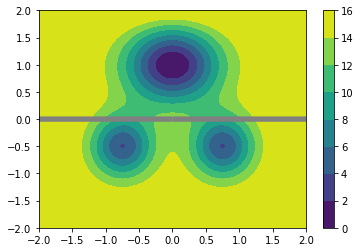

In [10]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

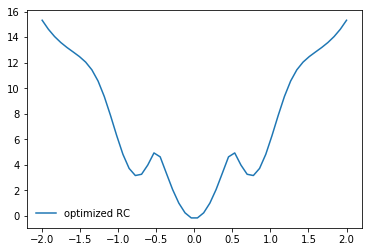

In [11]:
############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    md_traj,
    sgoop_params['cv_cols'],
    md_traj['weights'].values,
    sgoop_params['rc_bins'],
    sgoop_params['kde'],
    sgoop_params['bw']
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()

In [12]:
def double_sgoop_potential(x, y):
    return (
        -12 * np.exp(-4.5 * np.square(x + 0.55) - 3 * np.square(y + 0.5))
        - 16 * np.exp(-2 * np.square(x) - 2 * np.square(y - 1))
        - 12 * np.exp(-4.5 * np.square(x - 0.55) - 3 * np.square(y + 0.5))
        + 0.05 * (np.power(x, 6) + np.power(y, 6))
    )


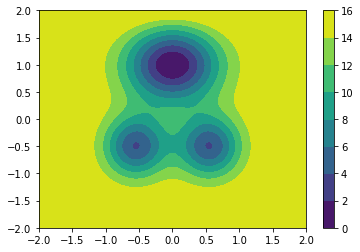

In [13]:
# calculate 2D potential energy surface
xaxis = np.linspace(-2.0, 2.0, 100)
yaxis = np.linspace(-2.0, 2.0, 100)

potential_energy_surface = double_sgoop_potential(
    xaxis[:, None], yaxis[None, :]
) 

# shift and clip high energy values for visualization
max_val = 16
shifted_pes = potential_energy_surface - potential_energy_surface.min()
shifted_pes[shifted_pes > max_val] = max_val

# plot potential energy surface
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')

In [14]:
# intialize empty pandas DataFrame to hold mock MD traj
md_traj = pd.DataFrame(
    columns=['x', 'y', 'weights']
)
x_col = []
y_col = []
weight_col = []

# step through potential energy surface, assigning weight (probability)
# to each square.
for idx, energy in np.ndenumerate(potential_energy_surface):
    x = xaxis[idx[0]]
    y = yaxis[idx[1]]
    x_col.append(x)
    y_col.append(y)
    weight_col.append(np.exp(-energy))
md_traj['x'] = x_col
md_traj['y'] = y_col
md_traj['weights'] = weight_col

In [15]:
from sgoop.sgoop import sgoop, md_prob

In [16]:
# specify columns you want to require
sgoop_params = {
    # specify rbias and cv column names
    'cv_cols': ['x', 'y'],
    # adjust sgoop params
    'rc_bins': 50,
    'wells': 3,
    'd': 4,
    'kde': True,
    'bw': 0.01,
    'diffusivity': 1.0
}


rc 0:  angle:  0.000  sg:  0.042
rc 1:  angle:  0.083  sg:  0.005
rc 2:  angle:  0.165  sg:  0.008
rc 3:  angle:  0.248  sg:  0.006
rc 4:  angle:  0.331  sg:  0.000
rc 5:  angle:  0.413  sg:  0.007
rc 6:  angle:  0.496  sg:  0.013
rc 7:  angle:  0.579  sg:  0.012
rc 8:  angle:  0.661  sg:  0.012
rc 9:  angle:  0.744  sg:  0.013
rc10:  angle:  0.827  sg:  0.005
rc11:  angle:  0.909  sg:  0.016
rc12:  angle:  0.992  sg:  0.023
rc13:  angle:  1.075  sg:  0.018
rc14:  angle:  1.157  sg:  0.007
rc15:  angle:  1.240  sg:  0.007
rc16:  angle:  1.323  sg:  0.013
rc17:  angle:  1.405  sg:  0.017
rc18:  angle:  1.488  sg:  0.028
rc19:  angle:  1.571  sg:  0.037
optimized RC: [1. 0.]
spectral gap: 0.04239133934515871


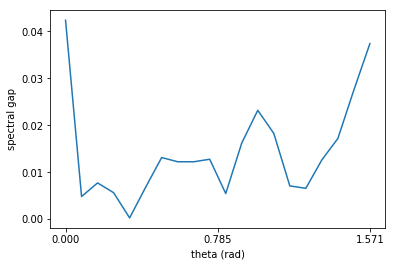

In [17]:
# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    prob, grid = md_prob(
        rc,
        md_traj,
        sgoop_params['cv_cols'],
        md_traj['weights'].values,
        sgoop_params['rc_bins'],
        sgoop_params['kde'],
        sgoop_params['bw']
    )
    # calculate spectral gap
    sg[idx] = sgoop(
        prob,
        None,
        sgoop_params['d'],
        sgoop_params['wells'],
        sgoop_params['diffusivity'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

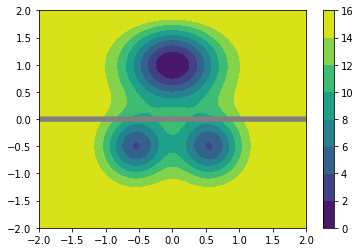

In [18]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

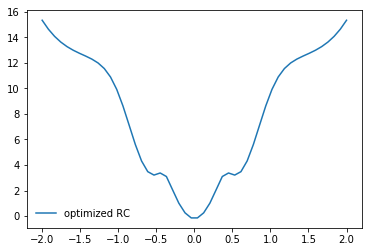

In [19]:
############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    md_traj,
    sgoop_params['cv_cols'],
    md_traj['weights'].values,
    sgoop_params['rc_bins'],
    sgoop_params['kde'],
    sgoop_params['bw']
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()

In [20]:
# Fails self consistency

In [21]:
# specify columns you want to require
sgoop_params = {
    # specify rbias and cv column names
    'cv_cols': ['x', 'y'],
    # adjust sgoop params
    'rc_bins': 50,
    'wells': 2,
    'd': 4,
    'kde': True,
    'bw': 0.01,
    'diffusivity': 1.0
}

rc 0:  angle:  0.000  sg:  0.000
rc 1:  angle:  0.083  sg:  0.001
rc 2:  angle:  0.165  sg:  0.020
rc 3:  angle:  0.248  sg:  0.040
rc 4:  angle:  0.331  sg:  0.058
rc 5:  angle:  0.413  sg:  0.068
rc 6:  angle:  0.496  sg:  0.073
rc 7:  angle:  0.579  sg:  0.075
rc 8:  angle:  0.661  sg:  0.075
rc 9:  angle:  0.744  sg:  0.074
rc10:  angle:  0.827  sg:  0.074
rc11:  angle:  0.909  sg:  0.060
rc12:  angle:  0.992  sg:  0.056
rc13:  angle:  1.075  sg:  0.063
rc14:  angle:  1.157  sg:  0.074
rc15:  angle:  1.240  sg:  0.078
rc16:  angle:  1.323  sg:  0.073
rc17:  angle:  1.405  sg:  0.066
rc18:  angle:  1.488  sg:  0.056
rc19:  angle:  1.571  sg:  0.038
optimized RC: [0.32469947 0.94581724]
spectral gap: 0.07820450851365501


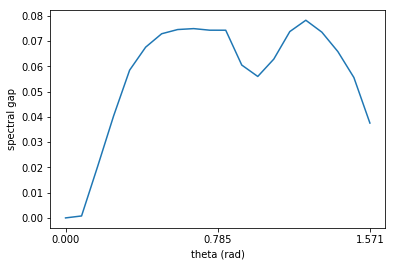

In [22]:
# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    prob, grid = md_prob(
        rc,
        md_traj,
        sgoop_params['cv_cols'],
        md_traj['weights'].values,
        sgoop_params['rc_bins'],
        sgoop_params['kde'],
        sgoop_params['bw']
    )
    # calculate spectral gap
    sg[idx] = sgoop(
        prob,
        None,
        sgoop_params['d'],
        sgoop_params['wells'],
        sgoop_params['diffusivity'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

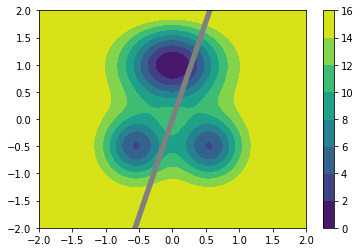

In [23]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

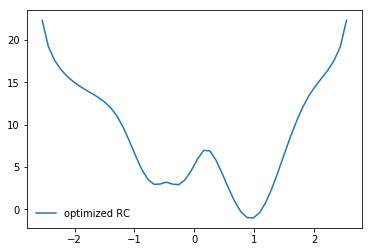

In [24]:
############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    md_traj,
    sgoop_params['cv_cols'],
    md_traj['weights'].values,
    sgoop_params['rc_bins'],
    sgoop_params['kde'],
    sgoop_params['bw']
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()

# with Monte Carlo simulation

In [25]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
import sgoop.analysis as analysis
# evaluate pdf on a grid using KDE with Gaussian kernel

### running a monte carlo simulation

In [27]:
def boltzmann_prob(pos0, pos1, potential, kt):
    e0 = potential(*pos0.T) 
    e1 = potential(*pos1.T)
    if e1 < e0:
        return 1.0
    return np.exp((e0 - e1) / kt)

np.random.seed(24)
def monte_carlo_simulation(
    potential,
    pos_0=(0, 0),
    step_size=(0.04, 0.04), 
    num_steps=50000, 
    kt=1.0
):
    pos = np.array(pos_0)
    results = np.ndarray([num_steps, 2])
    for idx in range(num_steps):
        step = np.array(
            random.choice(
                [(1, 0), (-1, 0),
                 (1, 1), (-1, 1),
                 (1, -1), (-1, -1),
                 (0, 1), (0, -1)]
            )
        ) * np.array(step_size)
        new_pos = pos + step
        prob = boltzmann_prob(pos, new_pos, potential, kt)
        if prob >= np.random.random():
            pos = new_pos
        results[idx, :] = pos
    return results

In [49]:
simulation_results = monte_carlo_simulation(
    single_sgoop_potential, kt=3, num_steps=100000
)

(-2, 2)

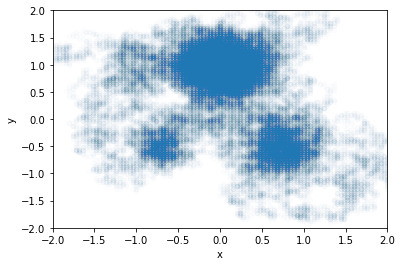

In [50]:
monte_carlo_traj = pd.DataFrame(simulation_results, columns=['x', 'y'])
monte_carlo_traj.plot.scatter(0, 1, alpha=0.01)
plt.ylim([-2, 2])
plt.xlim([-2, 2])

In [51]:
monte_carlo_traj['weights'] = np.exp(
    -single_sgoop_potential(
        monte_carlo_traj['x'].values, monte_carlo_traj['y'].values
    )
)

# finding optimal cv with sgoop

In [52]:
# specify columns you want to require
sgoop_params = {
    # specify rbias and cv column names
    'cv_cols': ['x', 'y'],
    # adjust sgoop params
    'rc_bins': 50,
    'wells': 3,
    'd': 4,
    'kde': False,
    'diffusivity': 1.0
}

rc 0:  angle:  0.000  sg:  0.040
rc 1:  angle:  0.083  sg:  0.007
rc 2:  angle:  0.165  sg:  0.013
rc 3:  angle:  0.248  sg:  0.010
rc 4:  angle:  0.331  sg:  0.007
rc 5:  angle:  0.413  sg:  0.009
rc 6:  angle:  0.496  sg:  0.009
rc 7:  angle:  0.579  sg:  0.009
rc 8:  angle:  0.661  sg:  0.006
rc 9:  angle:  0.744  sg:  0.007
rc10:  angle:  0.827  sg:  0.005
rc11:  angle:  0.909  sg:  0.039
rc12:  angle:  0.992  sg:  0.056
rc13:  angle:  1.075  sg:  0.061
rc14:  angle:  1.157  sg:  0.058
rc15:  angle:  1.240  sg:  0.047
rc16:  angle:  1.323  sg:  0.028
rc17:  angle:  1.405  sg:  0.006
rc18:  angle:  1.488  sg:  0.002
rc19:  angle:  1.571  sg:  0.009
optimized RC: [0.47594739 0.87947375]
spectral gap: 0.061100790087134316


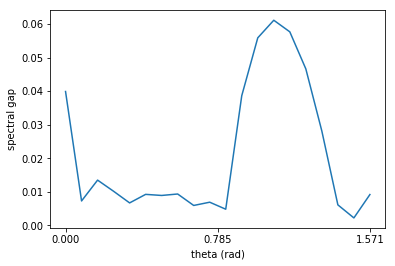

In [53]:
# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    prob, grid = md_prob(
        rc,
        monte_carlo_traj,
        sgoop_params['cv_cols'],
        monte_carlo_traj['weights'].values,
        sgoop_params['rc_bins'],
        sgoop_params['kde'],
    )
    # calculate spectral gap
    sg[idx] = sgoop(
        prob,
        None,
        sgoop_params['d'],
        sgoop_params['wells'],
        sgoop_params['diffusivity'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

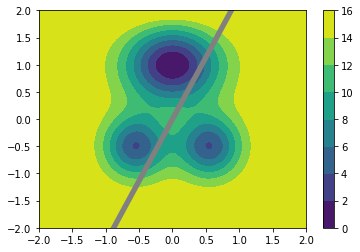

In [54]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

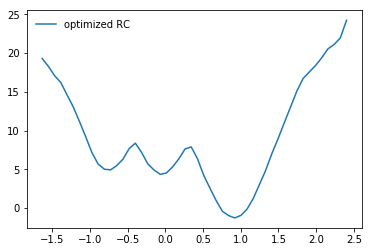

In [55]:
############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    monte_carlo_traj,
    sgoop_params['cv_cols'],
    monte_carlo_traj['weights'].values,
    sgoop_params['rc_bins'],
    sgoop_params['kde'],
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()

In [56]:
simulation_results = monte_carlo_simulation(
    double_sgoop_potential, kt=3, num_steps=100000
)

(-2, 2)

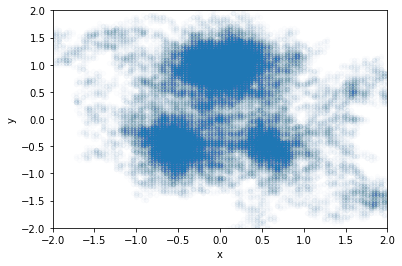

In [57]:
monte_carlo_traj = pd.DataFrame(simulation_results, columns=['x', 'y'])
monte_carlo_traj.plot.scatter(0, 1, alpha=0.01)
plt.ylim([-2, 2])
plt.xlim([-2, 2])

In [58]:
monte_carlo_traj['weights'] = np.exp(
    -single_sgoop_potential(
        monte_carlo_traj['x'].values, monte_carlo_traj['y'].values
    )
)

In [59]:
# specify columns you want to require
sgoop_params = {
    # specify rbias and cv column names
    'cv_cols': ['x', 'y'],
    # adjust sgoop params
    'rc_bins': 50,
    'wells': 3,
    'd': 4,
    'kde': False,
    'diffusivity': 1.0
}

rc 0:  angle:  0.000  sg:  0.031
rc 1:  angle:  0.083  sg:  0.000
rc 2:  angle:  0.165  sg:  0.006
rc 3:  angle:  0.248  sg:  0.009
rc 4:  angle:  0.331  sg:  0.015
rc 5:  angle:  0.413  sg:  0.009
rc 6:  angle:  0.496  sg:  0.001
rc 7:  angle:  0.579  sg:  0.006
rc 8:  angle:  0.661  sg:  0.005
rc 9:  angle:  0.744  sg:  0.002
rc10:  angle:  0.827  sg:  0.020
rc11:  angle:  0.909  sg:  0.048
rc12:  angle:  0.992  sg:  0.056
rc13:  angle:  1.075  sg:  0.057
rc14:  angle:  1.157  sg:  0.053
rc15:  angle:  1.240  sg:  0.035
rc16:  angle:  1.323  sg:  0.009
rc17:  angle:  1.405  sg:  0.011
rc18:  angle:  1.488  sg:  0.008
rc19:  angle:  1.571  sg:  0.000
optimized RC: [0.47594739 0.87947375]
spectral gap: 0.0574569627369752


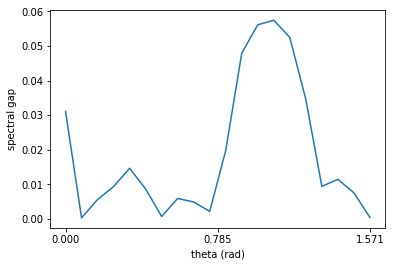

In [60]:
# evaluate spectral gap for various CVs
thetas = np.linspace(0, np.pi / 2, 20)
sg = np.zeros_like(thetas)
for idx, angle in enumerate(thetas):
    rc = angle_to_rc(angle)
    prob, grid = md_prob(
        rc,
        monte_carlo_traj,
        sgoop_params['cv_cols'],
        monte_carlo_traj['weights'].values,
        sgoop_params['rc_bins'],
        sgoop_params['kde'],
    )
    # calculate spectral gap
    sg[idx] = sgoop(
        prob,
        None,
        sgoop_params['d'],
        sgoop_params['wells'],
        sgoop_params['diffusivity'],
    )

    print(f'rc{idx:2d}:  angle: {angle:6.3f}  sg: {sg[idx]:6.3f}')

opt_theta = thetas[np.argmax(sg)]
opt_rc = angle_to_rc(opt_theta)
print(f'optimized RC: {opt_rc}')
print(f'spectral gap: {sg.max()}')

plt.plot(thetas, sg)
plt.xlabel('theta (rad)')
plt.ylabel('spectral gap')
plt.xticks([0, np.pi/4, np.pi/2])
plt.show()

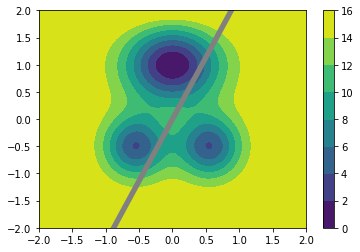

In [61]:
###########
# 2D plot #
###########
# plot energy
plt.contourf(xaxis, yaxis, shifted_pes.T)
cbar = plt.colorbar()
plt.set_cmap('viridis')
# cbar.ax.set_ylabel('G [kT]')
origin = [0, 0]
rcx = opt_rc[0]
rcy = opt_rc[1]
plt.quiver(*origin, rcx, rcy, scale=.1, color='grey', width=.02)
plt.quiver(*origin, -rcx, -rcy, scale=.1, color='grey', width=.02)
plt.show()

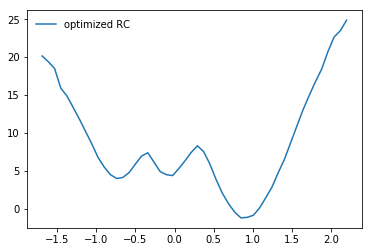

In [62]:
############
# pmf plot #
############
opt_prob, opt_grid = md_prob(
    opt_rc,
    monte_carlo_traj,
    sgoop_params['cv_cols'],
    monte_carlo_traj['weights'].values,
    sgoop_params['rc_bins'],
    sgoop_params['kde'],
)

# initialize plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# plot pmf from probability
plt.plot(opt_grid, -np.ma.log(opt_prob), label="optimized RC")

plt.legend(frameon=False)
plt.show()